## AML Project Source Code

#  Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy import sparse

# Data Loading and Cleaning

In [2]:
#Import dataset
Spotify_API_data = pd.read_csv("Spotify_Dataset_V3.csv", delimiter = ";")

# Some songs with identical titles appear in the dataset with different ids, so I will make all
# songs with the same title use the same URI.
# Find the first id to appear for every song title and create a series where each song title is mapped to the first URI found for that title.
title_to_uri = Spotify_API_data.groupby('Title')['id'].first()
# Update all entries in the original DataFrame to use the common URI between titles using map method in pandas.
Spotify_API_data['id'] = Spotify_API_data['Title'].map(title_to_uri)


# Feature Creation


Creating the artist count feature:

In [3]:
#Count number of songs by each artist and append as column in original dataset.
artistcounts = Spotify_API_data.groupby("Artist (Ind.)")['Title'].count().reset_index()
artistcounts = artistcounts.rename(columns = {"Title" : "Artist_Count"})
Spotify_API_data = pd.merge(Spotify_API_data, artistcounts, on="Artist (Ind.)", how="left")

Getting the duration, key, liveness, mode and explicit tag features from the spotify API. (CSV generated in "Spotify Scraper.py")

In [4]:
extra_features_from_api = pd.read_csv("Spotify_API_Features.csv", index_col = 0).drop("duration_ms", axis = 1)
Spotify_API_data = pd.merge(Spotify_API_data, extra_features_from_api, on="id", how = "left")
Spotify_API_data

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL,Artist_Count,key,liveness,mode,explicit
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,171,5,0.0837,0,False
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,903,5,0.0837,0,False
2,2,WHERE SHE GOES,Bad Bunny,29/05/2023,0.652,0.800,-4019.0,0.061,0.143,0.629,...,Latin-America,199,199.0,7ro0hRteUMfnOioTFI5TG1,https://open.spotify.com/track/7ro0hRteUMfnOio...,16624,9,0.1120,0,True
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",29/05/2023,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,147,2,0.0756,0,True
4,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",29/05/2023,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,903,2,0.0756,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651931,197,Oh Lord,MiC LOWRY,01/01/2017,0.273,0.794,-6644.0,0.068,0.022,0.000,...,Europe,4,4.0,1sTUEdVO85YU8Ymk2jeAls,https://open.spotify.com/track/1sTUEdVO85YU8Ym...,25,7,0.0616,0,False
651932,198,Superstition - Single Version,Stevie Wonder,01/01/2017,0.650,0.658,-10908.0,0.085,0.089,0.004,...,Anglo-America,3,3.0,1h2xVEoJORqrg71HocgqXd,https://open.spotify.com/track/5lXcSvHRVjQJ3LB...,47,8,0.0385,1,False
651933,199,Secrets,The Weeknd,01/01/2017,0.665,0.771,-5779.0,0.053,0.016,0.000,...,Anglo-America,2,2.0,66W1rVTnEv86dIkFhoiElg,https://open.spotify.com/track/3DX4Y0egvc0slLc...,10050,6,0.1950,0,True
651934,200,Ni**as In Paris,"JAY-Z, Kanye West",01/01/2017,0.757,0.882,-6125.0,0.248,0.076,0.000,...,Anglo-America,1,1.0,2KpCpk6HjXXLb7nnXoXA5O,https://open.spotify.com/track/2KpCpk6HjXXLb7n...,110,1,0.2510,1,True


Drop column we don't need

In [ ]:
Spotify_API_data = Spotify_API_data.drop(["Title", "Artists", "# of Artist", "Artist (Ind.)", "# of Nationality", "Points (Ind for each Artist/Nat)", "Song URL", "Continent"], axis = 1)

Create a dataframe containing the features for each id.

In [ ]:
features = Spotify_API_data.drop(['Rank', 'Date', 'Points (Total)'], axis = 1).groupby('id').first().reset_index()

Use one-hot encoding for the categorical features and drop the ids

In [ ]:
features_encoded = pd.get_dummies(features, columns=['Nationality', 'explicit'])

# Feature Scaling

### Create scaled X from features_from_models using min_max scaler

In [ ]:
#Drop categorical features if not done already.
if "id" in features.columns:
    features_numerical = features.copy().drop(["id"], axis=1)
else:
    features_numerical = features.copy(deep = True)
if "Nationality" in features_numerical.columns:
    features_numerical = features_numerical.drop(["Nationality"], axis=1)
if "explicit" in features_numerical.columns:
    features_numerical = features_numerical.drop(["explicit"], axis=1)

# Apply MinMaxScaler
scaler = MinMaxScaler()

features_numerical_scaled = pd.DataFrame(scaler.fit_transform(features_numerical), columns=features_numerical.columns)

#Create features_for_EDA dataframe
features_for_EDA = pd.merge(pd.DataFrame(features_numerical_scaled), features[["Nationality", 'explicit', "id"]], left_index=True, right_index=True)

#Create X dataframe
features_categorical = features_encoded.filter(like='id', axis=1).join(features_encoded.filter(like='explicit', axis=1)).join(features_encoded.filter(like='Nationality', axis=1))
X = pd.merge(features_categorical, features_numerical_scaled, left_index=True, right_index=True)

# Convert all int columns in X to np.float64
for col in X.select_dtypes(include=['int']):
  X[col] = X[col].astype(np.float64)

# Target Creation

In [ ]:
#Convert date column to datetime.
Spotify_API_data['Date'] = pd.to_datetime(Spotify_API_data['Date'], format='%d/%m/%Y')

if not pd.api.types.is_datetime64_any_dtype(Spotify_API_data['Date']):
   Spotify_API_data['Date'] = pd.to_datetime(Spotify_API_data['Date'])

In [ ]:
grouped_dataset = Spotify_API_data.groupby(['id']) #Grouped Data by id
#Find min rank, max points and days on chart.
sort_rank = grouped_dataset['Rank'].min()
sort_points = grouped_dataset['Points (Total)'].max()
start_date = grouped_dataset['Date'].min()
end_date = grouped_dataset['Date'].max()
duration_days = (end_date - start_date).dt.days #Cal


#calculate the duration of songs on the chart
duration_weeks = (duration_days / 7).round().astype(int) #For EDA only

Create dataframe containing the targets for each entry

In [ ]:
targets = pd.DataFrame({
    'Highest Rank (As Rank)': sort_rank,
    'Number of weeks on Chart': duration_weeks,
    'Highest Rank (As Points)': sort_points,
    'Number of days on Chart': duration_days
}).reset_index()

#### Create separate target dataframes for models and for EDA

In [ ]:
columns_for_models = ["id", "Highest Rank (As Points)", 'Number of days on Chart']
columns_for_EDA = ["id", "Highest Rank (As Rank)", 'Number of weeks on Chart', "Highest Rank (As Points)", 'Number of days on Chart']

targets_for_models = targets[columns_for_models]
targets_for_EDA = targets[columns_for_EDA]

# Ensure order of songs are the same in X and targets dataframes

### Force order to match in X, targets_for_models and targets_for_EDA

In [ ]:
X = X.sort_values(by='id').reset_index()
features = features.sort_values(by='id').reset_index()
targets_for_models = targets_for_models.sort_values(by='id').reset_index()
targets_for_EDA = targets_for_EDA.sort_values(by='id').reset_index()

### Check order matches in X, features, targets_for_EDA and targets_for_models

In [ ]:
id_match = (X['id'] == targets_for_models['id']).all()

if id_match:
    print("The 'id' columns match.")
else:
    print("The 'id' columns do not match.")

The 'id' columns match.


In [ ]:
id_match = (features['id'] == targets_for_models['id']).all()

if id_match:
    print("The 'id' columns match.")
else:
    print("The 'id' columns do not match.")

The 'id' columns match.


In [ ]:
id_match = (X['id'] == targets_for_EDA['id']).all()

if id_match:
    print("The 'id' columns match.")
else:
    print("The 'id' columns do not match.")

The 'id' columns match.


In [ ]:
id_match = (features['id'] == targets_for_EDA['id']).all()

if id_match:
    print("The 'id' columns match.")
else:
    print("The 'id' columns do not match.")

The 'id' columns match.


### Drop ID and index columns from final DataFrames

In [ ]:
X = X.drop("id", axis=1)
X = X.drop("index", axis=1)
features = features.drop("id", axis=1)
features = features.drop("index", axis=1)
targets_for_EDA = targets_for_EDA.drop("id", axis = 1)
targets_for_models = targets_for_models.drop("id", axis = 1)

Retain feature names for feature importance step.

In [ ]:
feature_names = X.columns

# Get Target Arrays for Models

In [ ]:
y_points = targets_for_models["Highest Rank (As Points)"]
y_days = targets_for_models["Number of days on Chart"]

# Convert ys to np.float64
y_points = y_points.astype(np.float64)
y_days = y_days.astype(np.float64)

# Exploratory Data Analysis

#### EDA of features

Check for null values

In [ ]:
null_counts = features_for_EDA.isnull().sum()

null_counts_df = pd.DataFrame({'Column Name': null_counts.index, 'Null Count': null_counts.values})

null_counts_df

,Column Name,Null Count
0,Danceability,0
1,Energy,0
2,Loudness,0
3,Speechiness,0
4,Acousticness,0
5,Instrumentalness,0
6,Valence,0
7,Artist_Count,0
8,key,0
9,liveness,0


Descriptive statistics

In [ ]:
features_for_EDA.describe()

,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Artist_Count,key,liveness,mode
count,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000,7412.000000
mean,0.661817,0.637427,0.796669,0.116811,0.234477,0.014834,0.485179,0.131552,0.475801,0.169611,0.574339
std,0.162210,0.171803,0.087964,0.127895,0.248938,0.088557,0.237691,0.191255,0.331450,0.147464,0.494476
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.559211,0.530777,0.752244,0.024364,0.040241,0.000000,0.300420,0.007881,0.090909,0.080967,0.000000
50%,0.680921,0.651867,0.798327,0.060381,0.139839,0.000000,0.482143,0.052578,0.454545,0.109780,1.000000
75%,0.780976,0.762866,0.841770,0.176907,0.352113,0.000000,0.665966,0.177164,0.727273,0.210988,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Distribution of Nationality categorical variable

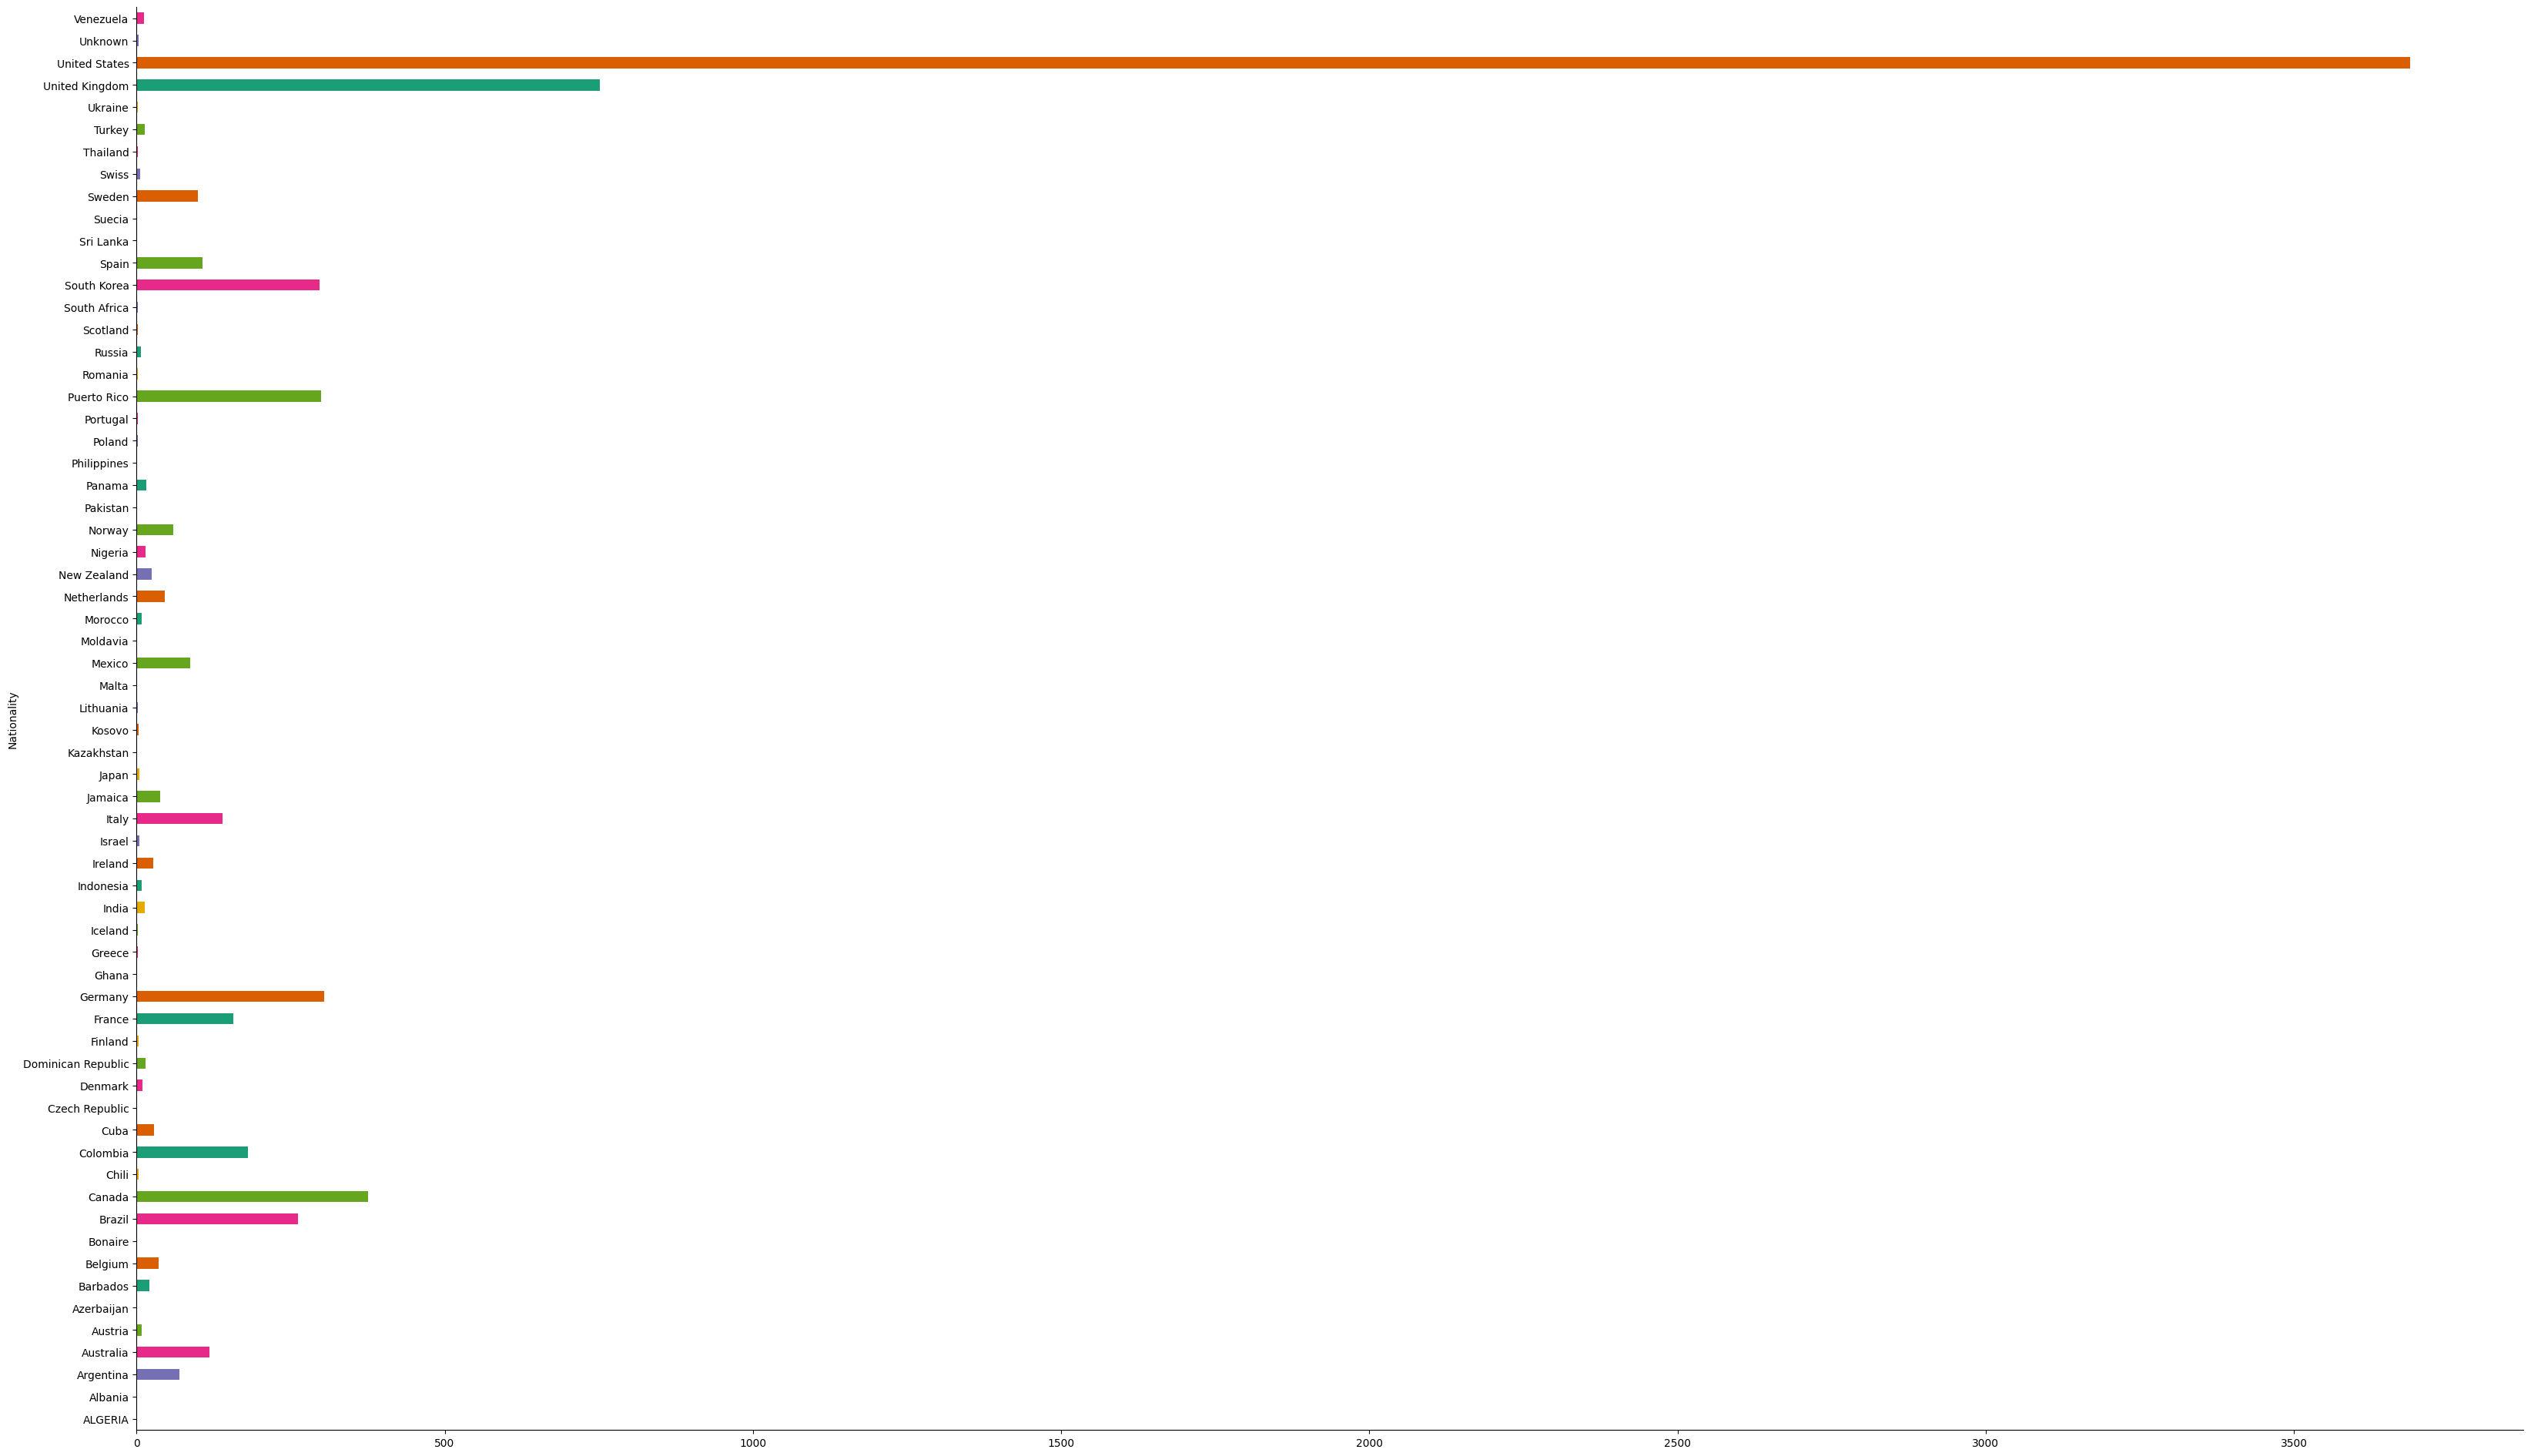

In [ ]:
plt.figure(figsize=(40, 24))
features_for_EDA.groupby('Nationality').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Correlation Matrix of Continuous Features

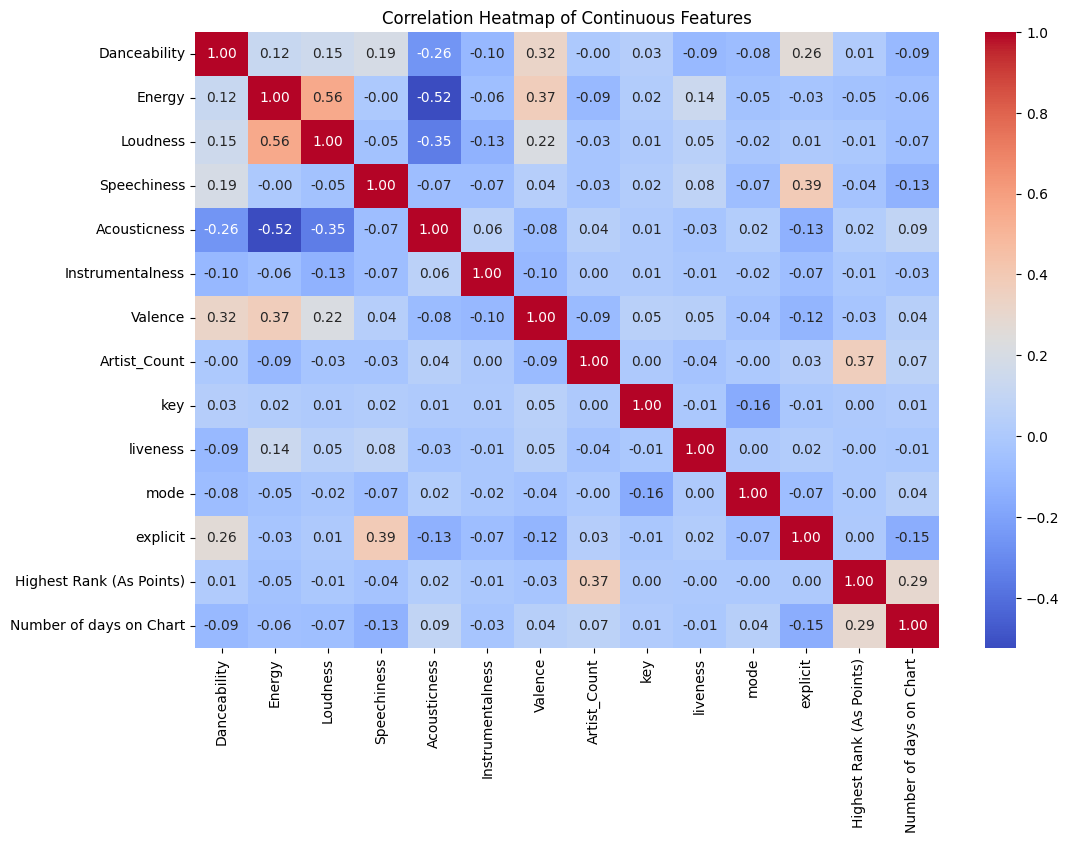

In [ ]:
correlation_targets = targets_for_EDA.drop(["Highest Rank (As Rank)", "Number of weeks on Chart"], axis=1) #Drop rank and weeks.

correlation_df = pd.merge(features_for_EDA, correlation_targets, left_index=True, right_index=True) #Merge features and correlation targets

correlation_df = correlation_df.drop("index", axis=1) #Drop pesky index column

correlation_matrix = correlation_df.corr(numeric_only = True) #Generate correlation matrix

plt.figure(figsize=(12, 8)) #Set figsize

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm') #Plot heatmap

plt.title('Correlation Heatmap of Continuous Features') #Set title

plt.show()

#### EDA of targets

Plot distribution of weeks on chart.

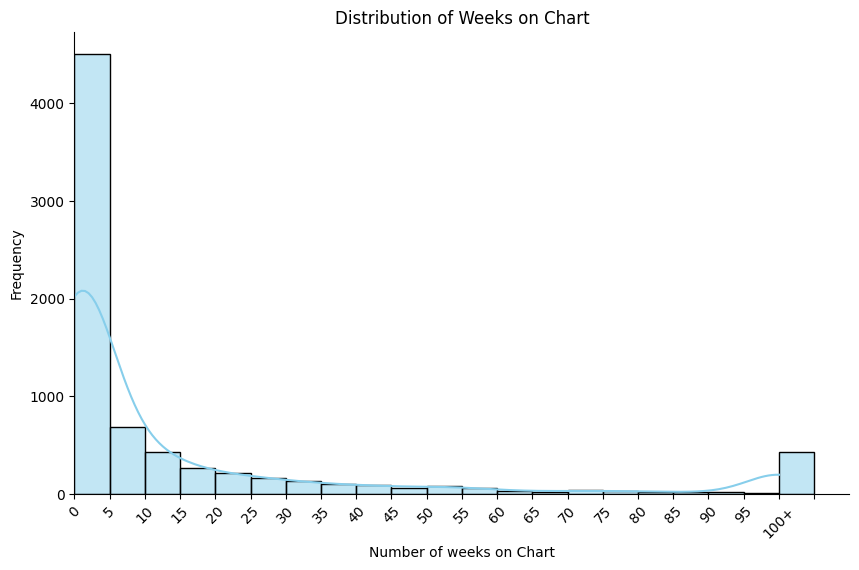

In [ ]:
# Create a new DataFrame for plotting
plotting_targets = pd.DataFrame()

#Change value for all songs on the charts for 100 or more weeks as 100 weeks so we can bin them as 100+
plotting_targets['Adjusted Weeks'] = targets_for_EDA['Number of weeks on Chart'].apply(lambda x: 100 if x >= 100 else x)

# Set figsize
plt.figure(figsize=(10, 6))

# Custom bins: 19 bins from 0 to 95, one for 95-100, and one additional bin for "100+"
bins = list(np.linspace(0, 95, 20)) + [100, 105]  # 105 is just to give visual space for 100+

# Plot the histogram
sns.histplot(plotting_targets['Adjusted Weeks'], bins=bins, kde=True, color='skyblue', edgecolor='black') #KDE because it looks cool.

# Set the labels and titles
plt.xlabel('Number of weeks on Chart')
plt.ylabel('Frequency')
plt.title('Distribution of Weeks on Chart')

# Customize x-axis labels and limits
xtick_values = np.arange(0, 101, 5).tolist() + [105]
xtick_labels = [f"{i}" for i in np.arange(0, 100, 5)] + ["100+", ""]
plt.xticks(ticks=xtick_values, labels=xtick_labels, rotation=45) #Rotate ticks 45º
plt.xlim(0, 110)  # Extend x-axis to include the "100+" bin

# Despine for nicer look.
sns.despine()

# Show the plot
plt.show()

Plot distribution of highest rank achieved.

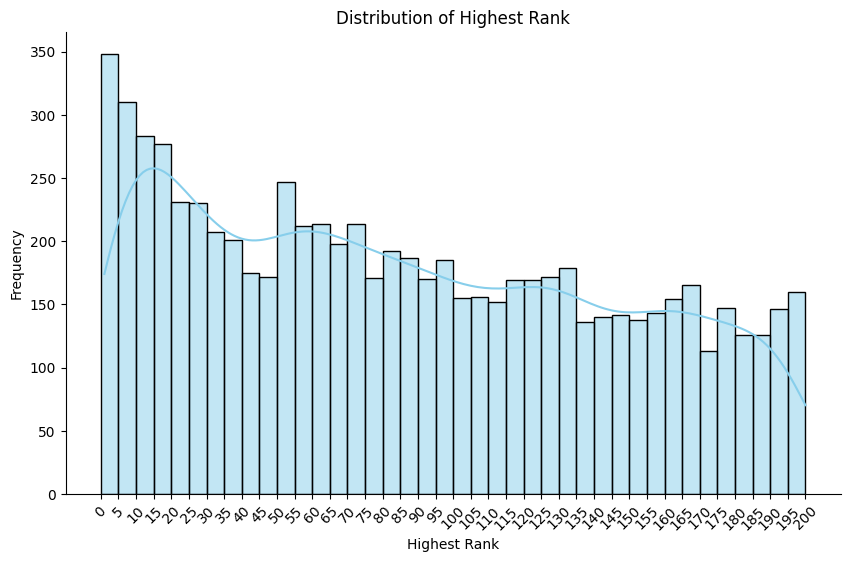

In [ ]:
#Set figsize
plt.figure(figsize=(10, 6))

#Create histogram with 40 bins (200/40 = 5)
bin_edges = np.linspace(0, 200, 41)

#Plot histogram.
ax = sns.histplot(targets_for_EDA['Highest Rank (As Rank)'], bins=bin_edges, kde=True, color='skyblue', edgecolor='black')

#Labels and titles.
plt.xlabel('Highest Rank')
plt.ylabel('Frequency')
plt.title('Distribution of Highest Rank')

# Set x-ticks and rotate 45º
plt.xticks(ticks=bin_edges, labels=[f"{int(x)}" for x in bin_edges])
plt.xticks(rotation=45)

sns.despine()
plt.show()

Check for null values

In [ ]:
targets_for_models.isnull().sum()

index                       0
Highest Rank (As Points)    0
Number of days on Chart     0
dtype: int64

Descriptive statistics

In [ ]:
targets_for_models.describe()

,index,Highest Rank (As Points),Number of days on Chart
count,7412.00000,7412.000000,7412.000000
mean,3705.50000,114.705613,143.929978
std,2139.80443,58.583921,360.066101
min,0.00000,1.000000,0.000000
25%,1852.75000,67.000000,1.000000
50%,3705.50000,121.000000,12.000000
75%,5558.25000,168.000000,97.000000
max,7411.00000,200.000000,2339.000000


# Data Segmentation

### Split datasets into 50% Training, 50% Test Sets

Encoded and scaled features

In [ ]:
#Split datasets into 60% test, 40% train.
X_days_train, X_days_test, y_days_train, y_days_test = train_test_split(X, y_days, test_size=0.6, random_state=42) #Random state 42 for reproducibility.
X_points_train, X_points_test, y_points_train, y_points_test = train_test_split(X, y_points, test_size=0.6, random_state=42)

#Set dataset names for identification when printing
X_days_train.name = "Days"
X_points_train.name = "Points"

# Memory Management

Create Sparse X matrices for training speed and memory management.

In [ ]:
X_days_train_sparse = sparse.csr_matrix(np.array(X_days_train))
X_points_train_sparse = sparse.csr_matrix(np.array(X_points_train))

X_days_train_sparse.name = "Days"
X_points_train_sparse.name = "Points"

# Optimisation and Training

### Linear Regression

In [ ]:
#Train linreg days model.
linreg_model_days = LinearRegression()
linreg_model_days.fit(X_days_train, y_days_train)

#Train linreg points model.
linreg_model_points = LinearRegression()
linreg_model_points.fit(X_points_train, y_points_train)

LinearRegression()

### Polynomial Regression

#### Training

In [ ]:
def train_polyreg(X, y):

  # Create a pipeline with polynomial features and linear regression
  polyreg_pipeline = Pipeline([
      ('poly', PolynomialFeatures()), #Creates polynomial values of features
      ('linear', LinearRegression()) #Find coefficients for each polynomial value.
  ])

  # Define the parameter grid to search over
  param_grid_polyreg = {'poly__degree': [2,3], 'linear__n_jobs': [-1]}

  # Initialize and fit GridSearchCV for 5-fold cross validation on polyreg pipeline.
  polyreg_model= GridSearchCV(polyreg_pipeline, param_grid_polyreg, cv=5, verbose=2)
  polyreg_model.fit(X, y)

  #Print best parameters.
  polyreg_best_params = polyreg_model.best_params_
  print("Best hyperparameters for " + X.name + " model (Polynomial Regression):", polyreg_best_params)

  #Return model.
  return polyreg_model

In [ ]:
#Fit polyreg model on days dataset.
polyreg_model_days = train_polyreg(X_days_train_sparse, y_days_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..................linear__n_jobs=-1, poly__degree=2; total time=   2.0s
[CV] END ..................linear__n_jobs=-1, poly__degree=2; total time=   1.2s
[CV] END ..................linear__n_jobs=-1, poly__degree=2; total time=   1.9s
[CV] END ..................linear__n_jobs=-1, poly__degree=2; total time=   1.9s
[CV] END ..................linear__n_jobs=-1, poly__degree=2; total time=   1.3s
[CV] END ..................linear__n_jobs=-1, poly__degree=3; total time= 1.6min
[CV] END ..................linear__n_jobs=-1, poly__degree=3; total time= 1.2min
[CV] END ..................linear__n_jobs=-1, poly__degree=3; total time= 1.5min
[CV] END ..................linear__n_jobs=-1, poly__degree=3; total time= 1.5min
[CV] END ..................linear__n_jobs=-1, poly__degree=3; total time= 1.4min
Best hyperparameters for Days model (Polynomial Regression): {'linear__n_jobs': -1, 'poly__degree': 2}


In [ ]:
#Fit polyreg model on points dataset.
polyreg_model_points = train_polyreg(X_points_train_sparse, y_points_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..................linear__n_jobs=-1, poly__degree=2; total time=   2.0s
[CV] END ..................linear__n_jobs=-1, poly__degree=2; total time=   2.4s
[CV] END ..................linear__n_jobs=-1, poly__degree=2; total time=   2.2s
[CV] END ..................linear__n_jobs=-1, poly__degree=2; total time=   1.9s
[CV] END ..................linear__n_jobs=-1, poly__degree=2; total time=   1.9s
[CV] END ..................linear__n_jobs=-1, poly__degree=3; total time= 1.2min
[CV] END ..................linear__n_jobs=-1, poly__degree=3; total time= 1.4min
[CV] END ..................linear__n_jobs=-1, poly__degree=3; total time= 1.5min
[CV] END ..................linear__n_jobs=-1, poly__degree=3; total time= 1.5min
[CV] END ..................linear__n_jobs=-1, poly__degree=3; total time= 1.5min
Best hyperparameters for Points model (Polynomial Regression): {'linear__n_jobs': -1, 'poly__degree': 2}


### Decision Tree Regressor

In [ ]:
def train_dt(X, y):

    # Define the parameter grid to search over (NOTE! I changed these values a few times before giving the results in the report.
    # I did this to ensure the values were generally not at the extrema of their ranges.)
    param_grid_dt = {
        'max_depth': np.linspace(1, 20, num=20, dtype=int),
        'min_samples_split': np.linspace(2, 20, num=19, dtype=int),
        'min_samples_leaf': np.linspace(2, 10, num=9, dtype=int),
        'max_features': [1.0, 'sqrt', 'log2'] #1.0: All the features, #sqrt: Square root total features, #log2: log2 of total features.
    }

    # Initialize and fit GridSearchCV for 5-fold cross validation on decision tree regressor.
    dt_model = GridSearchCV(DecisionTreeRegressor(), param_grid_dt, cv=5, verbose=2)
    dt_model.fit(X, y)

    # Print best parameters.
    dt_best_params = dt_model.best_params_
    print("Best hyperparameters for " + X.name + " model (Decision Tree):", dt_best_params)

    # Return model.
    return dt_model

In [ ]:
# Train decision tree on days data.
dt_model_days = train_dt(X_days_train_sparse, y_days_train)

Streaming output truncated to the last 5000 lines.
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=9; total time=   0.1s
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=9; total time=   0.1s
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=9; total time=   0.1s
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=9; total time=   0.1s
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=10; total time=   0.1s
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=10; total time=   0.1s
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=10; total time=   0.1s
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=10; total time=   0.1s
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=10; total time=   0.1s
[CV] END max_depth=19, max_features

In [ ]:
# Train decision tree on points data.
dt_model_points = train_dt(X_points_train_sparse, y_points_train)

Streaming output truncated to the last 5000 lines.
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=9; total time=   0.1s
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=9; total time=   0.1s
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=9; total time=   0.1s
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=9; total time=   0.1s
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=10; total time=   0.1s
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=10; total time=   0.1s
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=10; total time=   0.1s
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=10; total time=   0.1s
[CV] END max_depth=19, max_features=1.0, min_samples_leaf=3, min_samples_split=10; total time=   0.1s
[CV] END max_depth=19, max_features

### Random Forest Regressor

In [ ]:
def train_rf(X, y):

  # Define the parameter grid to search over (NOTE! I changed these values a few times before giving the results in the report.
  # I did this to ensure the values were generally not at the extrema of their ranges.)
  param_grid_rf = {
      'n_estimators': [250, 300, 350],
      'max_depth': np.linspace(5, 10, num=4, dtype=int),
      'min_samples_split': [2,5,10],
      'min_samples_leaf': [2, 5, 10],
      'max_features': [1.0, 'sqrt', 'log2'], #1.0: All the features, #sqrt: Square root total features, #log2: log2 of total features.
      'n_jobs': [-1]
  }

  # Initialize and fit GridSearchCV for 5-fold cross validation on random forest regressor.
  rf_model = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5, verbose=2)
  rf_model.fit(X, y)

  # Print best hyperparamers
  rf_best_params = rf_model.best_params_
  print("Best hyperparameters for " + X.name + " model  (Random Forest):", rf_best_params)

  # Return model.
  return rf_model

In [ ]:
#Train random forest model on days data.
rf_model_days = train_rf(X_days_train_sparse, y_days_train)

{'max_depth': 10,
 'max_features': 1.0,
 'min_samples_leaf': 15,
 'min_samples_split': 15,
 'n_estimators': 400,
 'n_jobs': -1}

In [ ]:
#Train random forest model on points data.
rf_model_points = train_rf(X_points_train_sparse, y_points_train)

{'max_depth': 8,
 'max_features': 1.0,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 350,
 'n_jobs': -1}

# Evaluation

### Training Accuracy

Linear Regression Metrics

In [ ]:
# Calculate training accuracy metrics for the days model
linreg_y_days_train_pred = linreg_model_days.predict(X_days_train)
linreg_days_train_r2 = r2_score(y_days_train, linreg_y_days_train_pred)
linreg_days_train_mae = mean_absolute_error(y_days_train, linreg_y_days_train_pred)
linreg_days_train_rmse = np.sqrt(mean_squared_error(y_days_train, linreg_y_days_train_pred))

# Calculate training accuracy metrics for the points model
linreg_y_points_train_pred = linreg_model_points.predict(X_points_train)
linreg_points_train_r2 = r2_score(y_points_train, linreg_y_points_train_pred)
linreg_points_train_mae = mean_absolute_error(y_points_train, linreg_y_points_train_pred)
linreg_points_train_rmse = np.sqrt(mean_squared_error(y_points_train, linreg_y_points_train_pred))

Polynomial Regression Metrics

In [ ]:
# Calculate training accuracy metrics for the days model
polyreg_y_days_train_pred = polyreg_model_days.predict(X_days_train)
polyreg_days_train_r2 = r2_score(y_days_train, polyreg_y_days_train_pred)
polyreg_days_train_mae = mean_absolute_error(y_days_train, polyreg_y_days_train_pred)
polyreg_days_train_rmse = np.sqrt(mean_squared_error(y_days_train, polyreg_y_days_train_pred))

# Calculate training accuracy metrics for the points model
polyreg_y_points_train_pred = polyreg_model_points.predict(X_points_train)
polyreg_points_train_r2 = r2_score(y_points_train, polyreg_y_points_train_pred)
polyreg_points_train_mae = mean_absolute_error(y_points_train, polyreg_y_points_train_pred)
polyreg_points_train_rmse = np.sqrt(mean_squared_error(y_points_train, polyreg_y_points_train_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


Decision Tree Regressor Metrics

In [ ]:
# Calculate training accuracy metrics for the days model
dt_y_days_train_pred = dt_model_days.predict(X_days_train)
dt_days_train_r2 = r2_score(y_days_train, dt_y_days_train_pred)
dt_days_train_mae = mean_absolute_error(y_days_train, dt_y_days_train_pred)
dt_days_train_rmse = np.sqrt(mean_squared_error(y_days_train, dt_y_days_train_pred))

# Calculate training accuracy metrics for the points model
dt_y_points_train_pred = dt_model_points.predict(X_points_train)
dt_points_train_r2 = r2_score(y_points_train, dt_y_points_train_pred)
dt_points_train_mae = mean_absolute_error(y_points_train, dt_y_points_train_pred)
dt_points_train_rmse = np.sqrt(mean_squared_error(y_points_train, dt_y_points_train_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Random Forest Regressor Metrics

In [ ]:
# Calculate training accuracy metrics for the days model
rf_y_days_train_pred = rf_model_days.predict(X_days_train)
rf_days_train_r2 = r2_score(y_days_train, rf_y_days_train_pred)
rf_days_train_mae = mean_absolute_error(y_days_train, rf_y_days_train_pred)
rf_days_train_rmse = np.sqrt(mean_squared_error(y_days_train, rf_y_days_train_pred))

# Calculate training accuracy metrics for the points model
rf_y_points_train_pred = rf_model_points.predict(X_points_train)
rf_points_train_r2 = r2_score(y_points_train, rf_y_points_train_pred)
rf_points_train_mae = mean_absolute_error(y_points_train, rf_y_points_train_pred)
rf_points_train_rmse = np.sqrt(mean_squared_error(y_points_train, rf_y_points_train_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Final Training Accuracy Tables

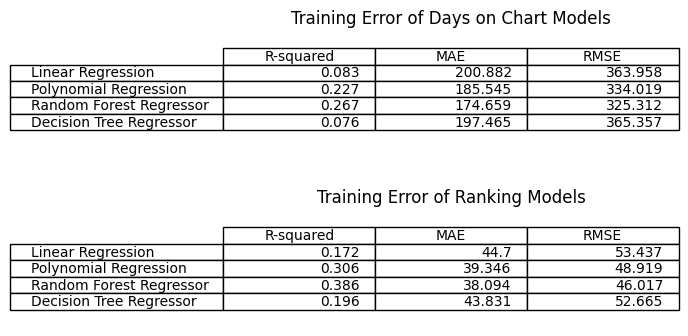

In [ ]:
#Create dataframes storing performance metrics (as columns) for each model (as rows)

days_training_accuracy_df = pd.DataFrame({
    'R-squared': [linreg_days_train_r2, polyreg_days_train_r2, rf_days_train_r2, dt_days_train_r2],
    'MAE': [linreg_days_train_mae, polyreg_days_train_mae, rf_days_train_mae, dt_days_train_mae],
    'RMSE': [linreg_days_train_rmse, polyreg_days_train_rmse, rf_days_train_rmse, dt_days_train_rmse]
}, index=['Linear Regression', 'Polynomial Regression', 'Random Forest Regressor', 'Decision Tree Regressor'])

points_training_accuracy_df = pd.DataFrame({
    'R-squared': [linreg_points_train_r2, polyreg_points_train_r2, rf_points_train_r2, dt_points_train_r2],
    'MAE': [linreg_points_train_mae, polyreg_points_train_mae, rf_points_train_mae, dt_points_train_mae],
    'RMSE': [linreg_points_train_rmse, polyreg_points_train_rmse, rf_points_train_rmse, dt_points_train_rmse]
}, index=['Linear Regression', 'Polynomial Regression', 'Random Forest Regressor', 'Decision Tree Regressor'])

# Format the dataframes to have only three decimal places
days_training_accuracy_df = days_training_accuracy_df.round(3)
points_training_accuracy_df = points_training_accuracy_df.round(3)

# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 4))

# Hide the axes
for ax in axes:
    ax.axis('tight')
    ax.axis('off')

# Create the tables and adjust layout
table_days_training = axes[0].table(cellText=days_training_accuracy_df.values, colLabels=days_training_accuracy_df.columns, rowLabels=days_training_accuracy_df.index, loc='center')
table_days_training.auto_set_font_size(False)
table_days_training.set_fontsize(10)
table_days_training.scale(1.2, 1.2)

table_points_training = axes[1].table(cellText=points_training_accuracy_df.values, colLabels=points_training_accuracy_df.columns, rowLabels=points_training_accuracy_df.index, loc='center')
table_points_training.auto_set_font_size(False)
table_points_training.set_fontsize(10)
table_points_training.scale(1.2, 1.2)

# Add titles
axes[0].set_title('Training Error of Days on Chart Models', fontsize=12)
axes[1].set_title('Training Error of Ranking Models', fontsize=12)

# Add some padding between tables.
plt.tight_layout(pad=3.0)

# Display the tables
plt.show()

### Generalisation Error

Linear Regression Metrics

In [ ]:
# Calculate testing accuracy metrics for the days model
linreg_y_days_test_pred = linreg_model_days.predict(X_days_test)
linreg_days_test_r2 = r2_score(y_days_test, linreg_y_days_test_pred)
linreg_days_test_mae = mean_absolute_error(y_days_test, linreg_y_days_test_pred)
linreg_days_test_rmse = np.sqrt(mean_squared_error(y_days_test, linreg_y_days_test_pred))

# Calculate testing accuracy metrics for the points model
linreg_y_points_test_pred = linreg_model_points.predict(X_points_test)
linreg_points_test_r2 = r2_score(y_points_test, linreg_y_points_test_pred)
linreg_points_test_mae = mean_absolute_error(y_points_test, linreg_y_points_test_pred)
linreg_points_test_rmse = np.sqrt(mean_squared_error(y_points_test, linreg_y_points_test_pred))

Polynomial Regression Metrics

In [ ]:
# Calculate testing accuracy metrics for the days model
polyreg_y_days_test_pred = polyreg_model_days.predict(X_days_test)
polyreg_days_test_r2 = r2_score(y_days_test, polyreg_y_days_test_pred)
polyreg_days_test_mae = mean_absolute_error(y_days_test, polyreg_y_days_test_pred)
polyreg_days_test_rmse = np.sqrt(mean_squared_error(y_days_test, polyreg_y_days_test_pred))

# Calculate testing accuracy metrics for the points model
polyreg_y_points_test_pred = polyreg_model_points.predict(X_points_test)
polyreg_points_test_r2 = r2_score(y_points_test, polyreg_y_points_test_pred)
polyreg_points_test_mae = mean_absolute_error(y_points_test, polyreg_y_points_test_pred)
polyreg_points_test_rmse = np.sqrt(mean_squared_error(y_points_test, polyreg_y_points_test_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


Decision Tree Regressor Metrics

In [ ]:
# Calculate testing accuracy metrics for the days model using Decision Tree Regressor
dt_y_days_test_pred = dt_model_days.predict(X_days_test)
dt_days_test_r2 = r2_score(y_days_test, dt_y_days_test_pred)
dt_days_test_mae = mean_absolute_error(y_days_test, dt_y_days_test_pred)
dt_days_test_rmse = np.sqrt(mean_squared_error(y_days_test, dt_y_days_test_pred))

# Calculate testing accuracy metrics for the points model using Decision Tree Regressor
dt_y_points_test_pred = dt_model_points.predict(X_points_test)
dt_points_test_r2 = r2_score(y_points_test, dt_y_points_test_pred)
dt_points_test_mae = mean_absolute_error(y_points_test, dt_y_points_test_pred)
dt_points_test_rmse = np.sqrt(mean_squared_error(y_points_test, dt_y_points_test_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Random Forest Regressor Metrics

In [ ]:
# Calculate testing accuracy metrics for the days model
rf_y_days_test_pred = rf_model_days.predict(X_days_test)
rf_days_test_r2 = r2_score(y_days_test, rf_y_days_test_pred)
rf_days_test_mae = mean_absolute_error(y_days_test, rf_y_days_test_pred)
rf_days_test_rmse = np.sqrt(mean_squared_error(y_days_test, rf_y_days_test_pred))

# Calculate testing accuracy metrics for the points model
rf_y_points_test_pred = rf_model_points.predict(X_points_test)
rf_points_test_r2 = r2_score(y_points_test, rf_y_points_test_pred)
rf_points_test_mae = mean_absolute_error(y_points_test, rf_y_points_test_pred)
rf_points_test_rmse = np.sqrt(mean_squared_error(y_points_test, rf_y_points_test_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(



Create Testing Accuracy Tables

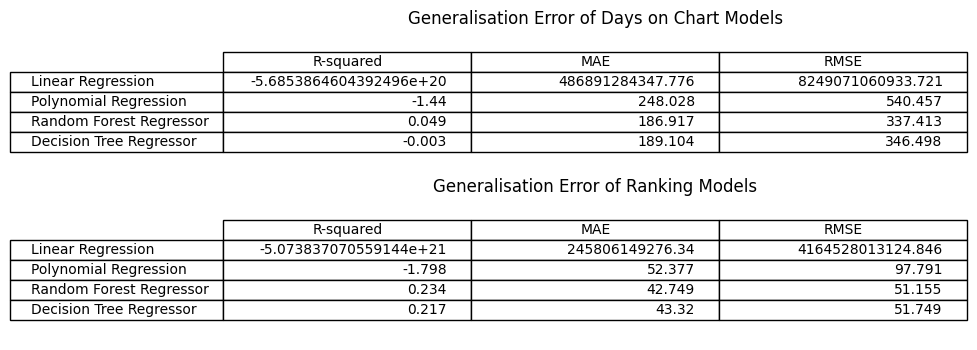

In [ ]:
#Create dataframes storing performance metrics (as columns) for each model (as rows)

days_testing_accuracy_df = pd.DataFrame({
    'R-squared': [linreg_days_test_r2.round(3), polyreg_days_test_r2, rf_days_test_r2, dt_days_test_r2],
    'MAE': [linreg_days_test_mae.round(3), polyreg_days_test_mae, rf_days_test_mae, dt_days_test_mae],
    'RMSE': [linreg_days_test_rmse.round(3), polyreg_days_test_rmse, rf_days_test_rmse, dt_days_test_rmse]
}, index=['Linear Regression', 'Polynomial Regression', 'Random Forest Regressor', 'Decision Tree Regressor'])


points_testing_accuracy_df = pd.DataFrame({
    'R-squared': [linreg_points_test_r2.round(3), polyreg_points_test_r2, rf_points_test_r2, dt_points_test_r2],
    'MAE': [linreg_points_test_mae.round(3), polyreg_points_test_mae, rf_points_test_mae, dt_points_test_mae],
    'RMSE': [linreg_points_test_rmse.round(3), polyreg_points_test_rmse, rf_points_test_rmse, dt_points_test_rmse]
}, index=['Linear Regression', 'Polynomial Regression', 'Random Forest Regressor', 'Decision Tree Regressor'])

# Format the dataframes to have only three decimal places
days_testing_accuracy_df = days_testing_accuracy_df.round(3)
points_testing_accuracy_df = points_testing_accuracy_df.round(3)

# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 4))

# Hide the axes
for ax in axes:
    ax.axis('tight')
    ax.axis('off')

# Create the tables and adjust layout
table_days = axes[0].table(cellText=days_testing_accuracy_df.values, colLabels=days_testing_accuracy_df.columns, rowLabels=days_testing_accuracy_df.index, loc='center')
table_days.auto_set_font_size(False)
table_days.set_fontsize(10)
table_days.scale(1.2, 1.2)

table_points = axes[1].table(cellText=points_testing_accuracy_df.values, colLabels=points_testing_accuracy_df.columns, rowLabels=points_testing_accuracy_df.index, loc='center')
table_points.auto_set_font_size(False)
table_points.set_fontsize(10)
table_points.scale(1.2, 1.2)

# Add titles
axes[0].set_title('Generalisation Error of Days on Chart Models', fontsize=12)
axes[1].set_title('Generalisation Error of Ranking Models', fontsize=12)

# Display the tables
plt.show()


# Feature Importances

### Calculate feature importances for best performing (random forest) model

In [ ]:
importances_rf_days = rf_model_days.best_estimator_.feature_importances_
importances_rf_points = rf_model_points.best_estimator_.feature_importances_

### Aggregate importances for one-hot encoded features

In [ ]:
#Initialise empty dicts to store importances.
importances_aggregated_days = {}
importances_aggregated_points = {}

#Iterate over feature names and importance values in rf days model.
for name, importance in zip(feature_names, importances_rf_days):
    if 'Nationality' in name or 'explicit' in name:
        # Combine under a common key
        key = 'Nationality' if 'Nationality' in name else 'explicit'
        # Get current value of aggregared feature importance (zero if it does not exist yet) and add encoded feature importance value
        importances_aggregated_days[key] = importances_aggregated_days.get(key, 0) + importance
    else: #For non one-hot encoded features just store the importance value in dict.
        importances_aggregated_days[name] = importance

#Repeat same steps for rf points model.
for name, importance in zip(feature_names, importances_rf_points):
    if 'Nationality' in name or 'explicit' in name:
        key = 'Nationality' if 'Nationality' in name else 'explicit'
        importances_aggregated_points[key] = importances_aggregated_points.get(key, 0) + importance
    else:
        importances_aggregated_points[name] = importance

### Create feature importance tables

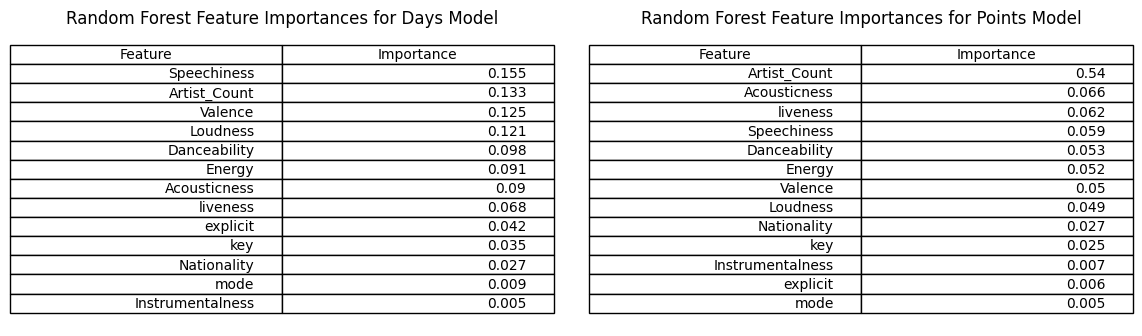

In [ ]:
# Create DataFrames for plotting
df_importances_days = pd.DataFrame(list(importances_aggregated_days.items()), columns=['Feature', 'Importance'])
df_importances_points = pd.DataFrame(list(importances_aggregated_points.items()), columns=['Feature', 'Importance'])

# Round the values to 3 decimal places
df_importances_days['Importance'] = df_importances_days['Importance'].round(3)
df_importances_points['Importance'] = df_importances_points['Importance'].round(3)

# Sort by descending order
df_importances_days = df_importances_days.sort_values(by='Importance', ascending=False)
df_importances_points = df_importances_points.sort_values(by='Importance', ascending=False)

# Set up figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Hide axes
for ax in axes:
    ax.axis('tight')
    ax.axis('off')

# Create the tables and adjust layout
table_importances_days = axes[0].table(cellText=df_importances_days.values, colLabels=df_importances_days.columns, loc='center')
table_importances_days.auto_set_font_size(False)
table_importances_days.set_fontsize(10)
table_importances_days.scale(1.2, 1.2)

table_importances_points = axes[1].table(cellText=df_importances_points.values, colLabels=df_importances_points.columns, loc='center')
table_importances_points.auto_set_font_size(False)
table_importances_points.set_fontsize(10)
table_importances_points.scale(1.2, 1.2)

# Add titles
axes[0].set_title('Random Forest Feature Importances for Days Model', fontsize=12)
axes[1].set_title('Random Forest Feature Importances for Points Model', fontsize=12)

# Add some padding.
plt.tight_layout(pad=3.0)

# Display the tables
plt.show()
